In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting

In [17]:
#load data 
stock_prices_df = pd.read_csv("faang_stocks.csv", index_col="Date")
stock_prices_df.index = pd.to_datetime(stock_prices_df.index)

returns_df = stock_prices_df.pct_change().dropna()

In [18]:
#benchmark portfolio
n = returns_df.shape[1]
ew_weights = np.repeat(1.0/n, n)

port_returns = returns_df.dot(ew_weights)
benchmark_exp_return = float(port_returns.mean() * 252)
benchmark_sharpe_ratio = float((port_returns.mean() / port_returns.std()) * np.sqrt(252))

print("Equal-Weight Portfolio:")
print("Expected Return (annualized):", benchmark_exp_return)
print("Sharpe Ratio (annualized):", benchmark_sharpe_ratio)

Equal-Weight Portfolio:
Expected Return (annualized): 0.23604765737238026
Sharpe Ratio (annualized): 0.7221868020795007


In [19]:
#Portfolio Optimization
mu = expected_returns.mean_historical_return(stock_prices_df, compounding=False)
cov = risk_models.sample_cov(stock_prices_df)

# Min Vol
ef_min = EfficientFrontier(mu, cov)
mv_weights = ef_min.min_volatility()
mv_portfolio = pd.Series(mv_weights).reindex(stock_prices_df.columns).fillna(0)
mv_return, mv_vol, mv_sharpe = ef_min.portfolio_performance()
mv_portfolio_vol = mv_vol

# Max Sharpe
ef_sharpe = EfficientFrontier(mu, cov)
ms_weights = ef_sharpe.max_sharpe(risk_free_rate=0)
ms_portfolio = pd.Series(ms_weights).reindex(stock_prices_df.columns).fillna(0)
ms_return, ms_vol, ms_sharpe = ef_sharpe.portfolio_performance()
ms_portfolio_sharpe = ms_sharpe

print("\nMin-Vol Portfolio Volatility (annualized):", mv_portfolio_vol)
print("Max-Sharpe Portfolio Sharpe Ratio (annualized):", ms_portfolio_sharpe)





Min-Vol Portfolio Volatility (annualized): 0.3030736711547464
Max-Sharpe Portfolio Sharpe Ratio (annualized): 0.8821809421501468


In [20]:
#Risk Analysis
# Value at Risk (95%)
VaR_95 = np.percentile(port_returns, 5)
# Conditional VaR (CVaR)
CVaR_95 = port_returns[port_returns <= VaR_95].mean()

print("\nRisk Metrics for Equal-Weight Portfolio:")
print("95% Value-at-Risk (daily):", VaR_95)
print("95% Conditional VaR (daily):", CVaR_95)



Risk Metrics for Equal-Weight Portfolio:
95% Value-at-Risk (daily): -0.03343644240086475
95% Conditional VaR (daily): -0.04826827994172229


In [21]:
#Risk contribution of each asset in Max-Sharpe portfolio
cov_matrix = risk_models.sample_cov(stock_prices_df)
weights = ms_portfolio.values
portfolio_var = weights.T @ cov_matrix.values @ weights
marginal_contrib = cov_matrix.values @ weights
risk_contrib = weights * marginal_contrib / portfolio_var
risk_contrib_series = pd.Series(risk_contrib, index=stock_prices_df.columns)


In [22]:
#Rolling volatility (simulate daily monitoring)
rolling_vol = port_returns.rolling(window=60).std() * np.sqrt(252)


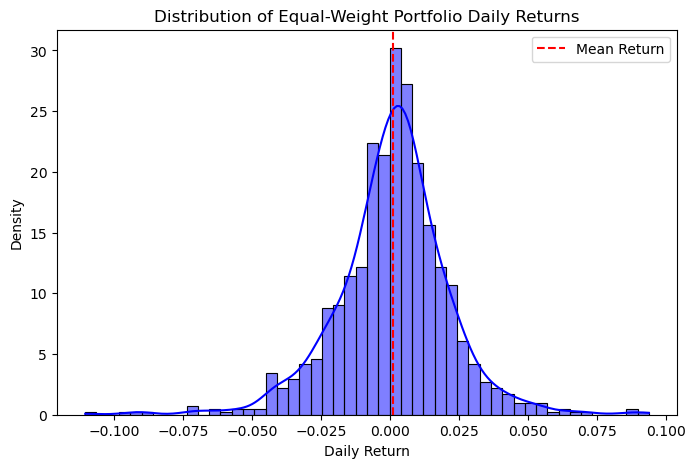

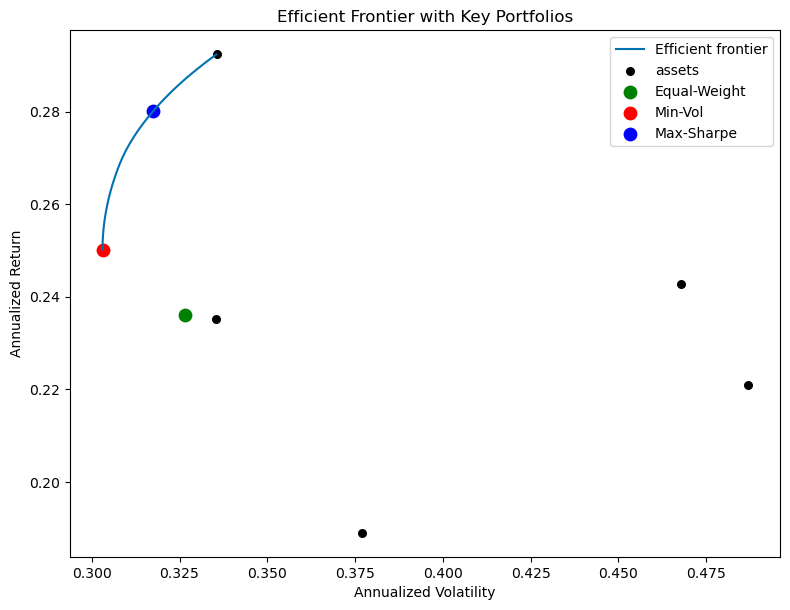

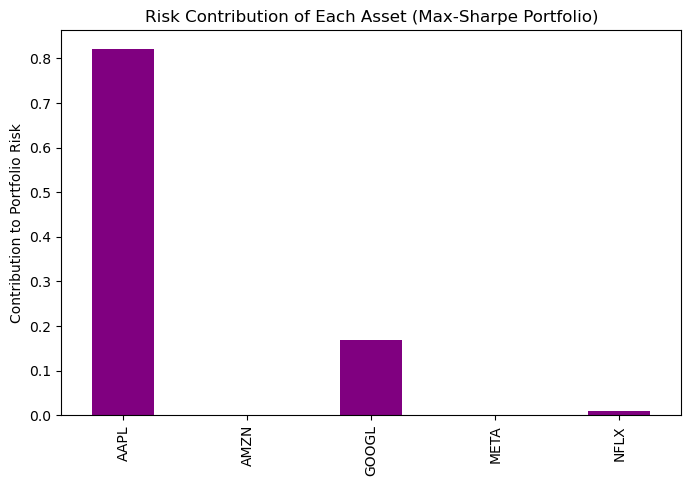

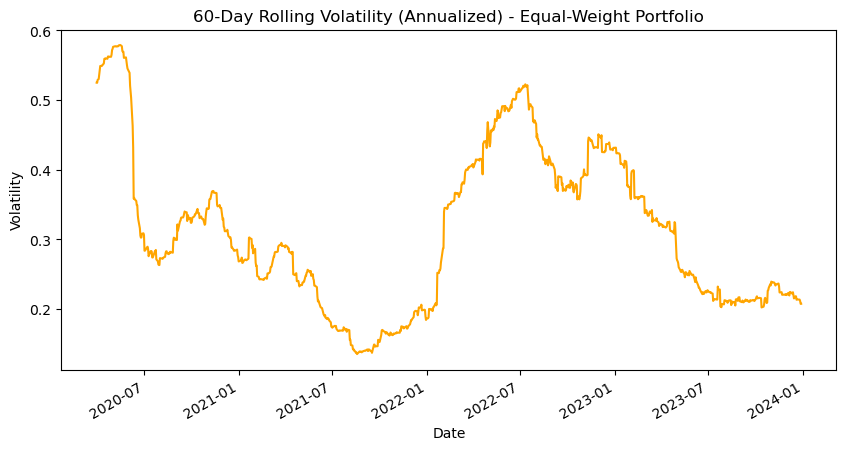

In [23]:
#Visualization
# (a) Distribution of portfolio returns
plt.figure(figsize=(8,5))
sns.histplot(port_returns, bins=50, kde=True, color="blue", stat="density")
plt.axvline(port_returns.mean(), color="red", linestyle="--", label="Mean Return")
plt.title("Distribution of Equal-Weight Portfolio Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# (b) Efficient Frontier
fig, ax = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(EfficientFrontier(mu, cov), ax=ax, show_assets=True)

# mark key portfolios
plt.scatter(np.std(port_returns)*np.sqrt(252), benchmark_exp_return, 
            marker="o", color="green", s=80, label="Equal-Weight")
plt.scatter(mv_vol, mv_return, 
            marker="o", color="red", s=80, label="Min-Vol")
plt.scatter(ms_vol, ms_return, 
            marker="o", color="blue", s=80, label="Max-Sharpe")
plt.title("Efficient Frontier with Key Portfolios")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend()
plt.show()

# (c) Risk Contribution (Max-Sharpe)
risk_contrib_series.plot(kind="bar", figsize=(8,5), color="purple")
plt.title("Risk Contribution of Each Asset (Max-Sharpe Portfolio)")
plt.ylabel("Contribution to Portfolio Risk")
plt.show()

# (d) Rolling Volatility
plt.figure(figsize=(10,5))
rolling_vol.plot(color="orange")
plt.title("60-Day Rolling Volatility (Annualized) - Equal-Weight Portfolio")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.show()